**For [stackoverflow](https://stackoverflow.com) issue [Why can't I get string with PIL and pytesseract?](https://stackoverflow.com/questions/57183997/why-cant-get-string-with-pil-and-pytesseract/57229158#57229158)**

In [1]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

In [2]:
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files (x86)/Tesseract-OCR/tesseract.exe"

**Files:**

In [3]:
data = Path.cwd() / 'data'

In [4]:
img_original = Image.open(data / '0244R.jpg')
img_new = Image.open(data / '0244R_clean.jpg')
img = [img_original, img_new]

# OCR Without Image Processing

In [5]:
img_original

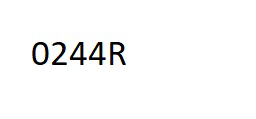

In [6]:
img_new

In [7]:
for x in img:
    print(f'OCR Result: {pytesseract.image_to_string(x)}\n')

OCR Result: 

OCR Result: 0244R



# Incorporate Image Processing

In [8]:
def image_smoothening(img):
    ret1, th1 = cv2.threshold(img, 88, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th3

In [9]:
def remove_noise_and_smooth(file_name):
    img = cv2.imread(str(file_name), 0)
    filtered = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 41)
    kernel = np.ones((1, 1), np.uint8)
    opening = cv2.morphologyEx(filtered, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img = image_smoothening(img)
    or_image = cv2.bitwise_or(img, closing)
    return or_image

Thresh: 0


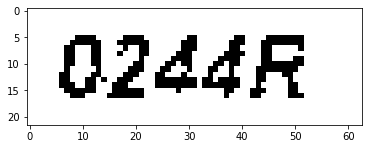

OCR Result: wo

5

20

 

 

O244R

 

Ft 2 2 0 30

Thresh: 1


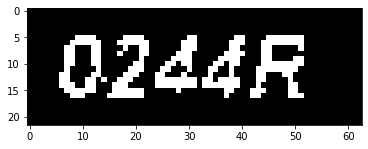

OCR Result: 5

20

Ed,

10 2 2 0 50

Thresh: 2


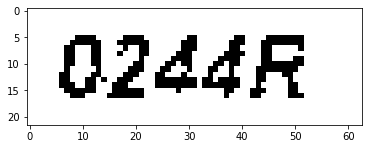

OCR Result: wo

5

20

 

 

O244R

 

Ft 2 2 0 30

Thresh: 3


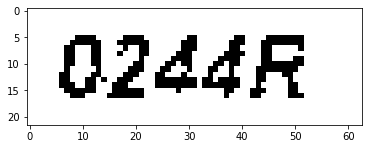

OCR Result: wo

5

20

 

 

O244R

 

Ft 2 2 0 30

Thresh: 4


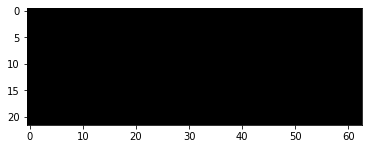

OCR Result: 10

2

50

Thresh: 0


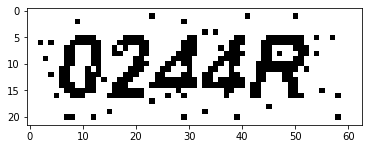

OCR Result: wo

5

20

Thresh: 1


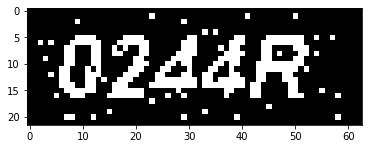

OCR Result: 

Thresh: 2


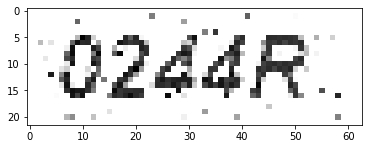

OCR Result: wo

5

20

 

 

$2d4R.

 

Fy 2 2 0 30

Thresh: 3


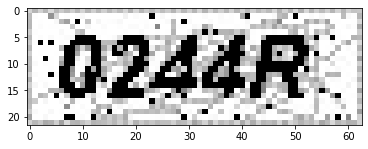

OCR Result: 

Thresh: 4


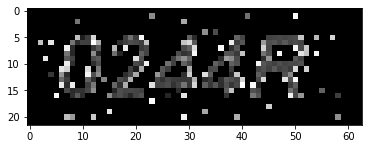

OCR Result: 



In [10]:
cv2_thresh_list = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV,
                   cv2.THRESH_TRUNC, cv2.THRESH_TOZERO,
                   cv2.THRESH_TOZERO_INV]

img1 = remove_noise_and_smooth(data / '0244R.jpg')
img2 = cv2.imread(str(data / '0244R.jpg'), 0)
for img in [img1, img2]:
    for item in cv2_thresh_list:
        print('Thresh: {}'.format(str(item)))
        _, thresh = cv2.threshold(img, 127, 255, item)
        plt.imshow(thresh, 'gray')
        f_name = f'{str(item)}.jpg'
        plt.savefig(f_name)
        plt.show()
        print('OCR Result: {}\n'.format(pytesseract.image_to_string(f_name)))